# Anàlisi de Resultats Experimentals: Realitats Construïdes

**Treball Final de Grau - Ciència de Dades Aplicada (UOC)**                      
**Autora:** Victòria Toribio Ruisoto  
**Data de Tancament de Mostra:** 7 de Desembre de 2025


## 1. Context i Objectius de l'Anàlisi
Aquest document recull el procediment de processament, neteja i anàlisi estadística de les dades recollides durant la fase experimental del projecte.

L'experiment, basat en un disseny factorial $2 \times 2$ (Inter-subjectes), s'ha dut a terme mitjançant una aplicació web pròpia (Google Apps Script). La fase de camp s'ha donat per finalitzada amb una mostra vàlida de **$N=139$ participants**, superant el llindar mínim establert a la planificació inicial.

### Objectius:
1.  **Validar la integritat de les dades:** Neteja de valors nuls i comprovació de l'aleatorietat en l'assignació de grups.
2.  **Contrastar les Hipòtesis de Recerca:**
    * **H1 (Polarització):** Els gràfics amb manipulació retòrica (B1/B2) generen un desplaçament d'opinió superior als neutres (A1/A2).
    * **H2 (Invisibilitat):** La confiança percebuda no disminueix significativament davant d'estímuls manipulats.

In [ ]:
# --- PAS 1: CONFIGURACIÓ DE L'ENTORN I CÀRREGA DE DADES ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import drive

# Configuració estètica dels gràfics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 # Alta resolució per a la memòria

# 1. Muntar Google Drive
drive.mount('/content/drive')

# 2. Càrrega del Dataset
file_path = '/content/drive/MyDrive/TFG/Fase5/Dades_experiment_TFG.csv'

try:
    df = pd.read_csv(file_path)
    print("✅ ARXIU CARREGAT AMB ÈXIT")
    print(f"Mostra total: {len(df)} participants")

    # Mostrem les primeres 3 files per verificar l'estructura
    display(df.head(3))

except FileNotFoundError:
    print("❌ ERROR: No s'ha trobat el fitxer.")
    print("Si us plau, verifica que la ruta.")

Mounted at /content/drive
✅ ARXIU CARREGAT AMB ÈXIT
Mostra total: 139 participants


,timestamp,id_participant,grup_experimental,s2_edat,s2_sexe,s2_estudis,s2_ideologia,s2_likert_educacio1,s2_likert_educacio2,s2_likert_immi1,s2_likert_immi2,s4_comprensio,s4_percep_claredat,s4_percep_confianca,s4_percep_paraules,s4_post_item1,s4_post_item2,s5_record_tema,s5_record_visual
0,20/11/2025 17:24:56,1763637828648,A1,26,dona,secundaris,6,4,4,4,4,2021,4,4,"Malbaratament, subinversió",4,5,estable,res
1,20/11/2025 17:26:19,1763637849327,A1,33,home,postgrau,3,1,1,1,1,2020,1,1,Normal,1,6,poca variació,pocs pics
2,20/11/2025 17:45:37,1763656341940,B2,33,home,secundaris,6,4,4,4,4,uniforme,4,4,preocupant,4,3,Molta inmigració,Els colors


## 2. Anàlisi Exploratòria de Dades (EDA)

Abans de procedir a la contrastació d'hipòtesis, realitzem una descripció tècnica del conjunt de dades per validar-ne l'estructura, els tipus de variables i la qualitat general de la mostra ($N=139$).

### 2.1. Diccionari de Variables
El dataset resultant consta de 19 columnes estructurades segons les seccions del qüestionari experimental:

| Variable | Tipus | Descripció |
| :--- | :--- | :--- |
| **Metadades** | | |
| `id_participant` | Numèric | Identificador únic anònim (Timestamp Unix). |
| `grup_experimental` | Categòric | Assignació aleatòria: A1 (Edu Control), B1 (Edu Persuasiu), A2 (Immi Control), B2 (Immi Persuasiu). |
| **Demogràfiques (S2)** | | |
| `s2_edat` | Numèric | Edat del participant. |
| `s2_sexe` | Categòric | Sexe. |
| `s2_estudis` | Ordinal | Nivell màxim d'estudis assolit. |
| `s2_ideologia` | Numèric (1-10) | Autoubicació ideològica (1=Esquerra, 10=Dreta). Inclou valors 'NSC'. |
| **Pre-Test (S2)** | | |
| `s2_likert_educacio[1-2]` | Likert (1-7) | Opinió inicial sobre inversió educativa i qualitat. |
| `s2_likert_immi[1-2]` | Likert (1-7) | Opinió inicial sobre impacte econòmic i saturació de serveis. |
| **Post-Test (S4)** | | |
| `s4_comprensio` | Nominal | Control d'atenció (Resposta correcta vs incorrecta). |
| `s4_percep_claredat` | Likert (1-7) | Valoració de la claredat visual del gràfic. |
| `s4_percep_confianca` | Likert (1-7) | Nivell de confiança inspirat per la visualització. |
| `s4_post_item[1-2]` | Likert (1-7) | Opinió posterior a l'estímul (mateixes preguntes que al Pre-Test). |
| **Qualitatives (S5)** | | |
| `s5_record_visual` | Text Lliure | Elements visuals recordats (memòria selectiva). |
| `s5_record_tema` | Text Lliure | Elements referents al tema recordats (memòria selectiva). |

In [ ]:
# --- PAS 2: EXPLORACIÓ INICIAL I DEMOGRAFIA ---

# 1. Resum Tècnic del Dataframe
print("--- INFO DEL DATASET ---")
df.info()

print("\n--- ESTADÍSTICS VARIABLES NUMÈRIQUES ---")
# Ens interessa especialment l'edat per veure el perfil
display(df[['s2_edat']].describe().T)

--- INFO DEL DATASET ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            139 non-null    object
 1   id_participant       139 non-null    int64 
 2   grup_experimental    139 non-null    object
 3   s2_edat              139 non-null    int64 
 4   s2_sexe              139 non-null    object
 5   s2_estudis           139 non-null    object
 6   s2_ideologia         139 non-null    object
 7   s2_likert_educacio1  139 non-null    int64 
 8   s2_likert_educacio2  139 non-null    int64 
 9   s2_likert_immi1      139 non-null    int64 
 10  s2_likert_immi2      139 non-null    int64 
 11  s4_comprensio        139 non-null    object
 12  s4_percep_claredat   139 non-null    int64 
 13  s4_percep_confianca  139 non-null    int64 
 14  s4_percep_paraules   139 non-null    object
 15  s4_post_item1        139 non-nul

,count,mean,std,min,25%,50%,75%,max
s2_edat,139.0,41.338129,14.515137,18.0,31.0,42.0,51.5,78.0


/tmp/ipython-input-1401583201.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='s2_sexe', data=df, ax=ax[1], palette="Accent")
/tmp/ipython-input-1401583201.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='s2_estudis', data=df, order=ordre_estudis, ax=ax[2], palette="viridis")


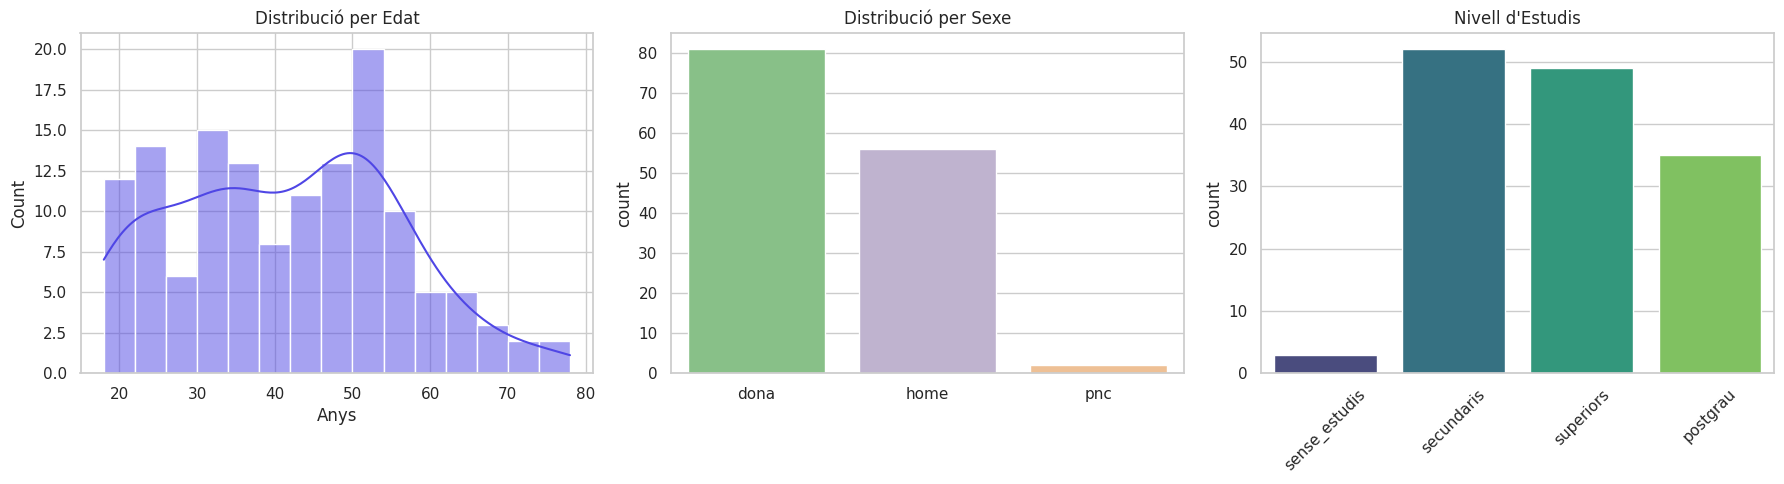

In [ ]:
# 2. Visualització de la Demografia de la Mostra
# És diversa la mostra?

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Gràfic 1: Distribució per Edat (Histograma)
sns.histplot(df['s2_edat'], kde=True, bins=15, ax=ax[0], color="#4f46e5")
ax[0].set_title('Distribució per Edat')
ax[0].set_xlabel('Anys')

# Gràfic 2: Distribució per Sexe (Pastís o Barres)
# Utilitzem countplot per simplicitat i claredat
sns.countplot(x='s2_sexe', data=df, ax=ax[1], palette="Accent")
ax[1].set_title('Distribució per Sexe')
ax[1].set_xlabel('')

# Gràfic 3: Nivell d'Estudis
# Ordenem lògicament els estudis, no alfabèticament
ordre_estudis = ['sense_estudis', 'secundaris', 'superiors', 'postgrau']
sns.countplot(x='s2_estudis', data=df, order=ordre_estudis, ax=ax[2], palette="viridis")
ax[2].set_title('Nivell d\'Estudis')
ax[2].set_xlabel('')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


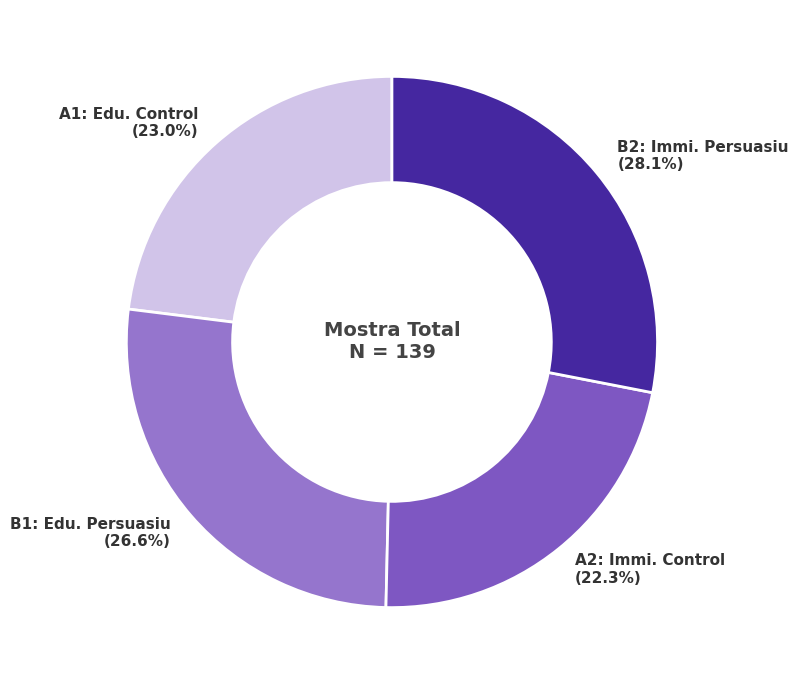

In [ ]:
import matplotlib.pyplot as plt

# 1. PREPARACIÓ DE DADES (Des del teu df)
# Comptem participants per grup
counts = df['grup_experimental'].value_counts()

# Assegurem l'ordre correcte (A1, B1, A2, B2) per la seqüència de colors
order = ['A1', 'B1', 'A2', 'B2']
sizes = [counts.get(g, 0) for g in order]
total = sum(sizes)

# 2. CONFIGURACIÓ VISUAL
labels_raw = [
    'A1: Edu. Control',     # Correspon al primer del llistat 'order'
    'B1: Edu. Persuasiu',
    'A2: Immi. Control',
    'B2: Immi. Persuasiu'
]

# Creem l'etiqueta combinada (Text + % real calculat)
labels_combined = [f"{label}\n({size/total*100:.1f}%)" for label, size in zip(labels_raw, sizes)]

# Paleta Seqüencial Lila (del clar al fosc)
colors_lila = ['#D1C4E9', '#9575CD', '#7E57C2', '#4527A0']

# 3. GENERACIÓ DEL GRÀFIC
fig, ax = plt.subplots(figsize=(10, 7))

wedges, texts = ax.pie(
    sizes,
    labels=labels_combined,     # Etiquetes al costat de cada tros
    labeldistance=1.1,          # Una mica separades per no tocar el color
    startangle=90,
    colors=colors_lila,
    textprops={'fontsize': 11, 'color': '#333', 'weight': 'bold'},
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 2} # Anell blanc
)

# Text central amb la N total real
plt.text(0, 0, f'Mostra Total\nN = {total}',
         ha='center', va='center', fontsize=14, fontweight='bold', color='#444')


plt.tight_layout()
plt.show()

/tmp/ipython-input-3120976724.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='grup_experimental', data=df, palette="Paired", order=['A1', 'B1', 'A2', 'B2'])


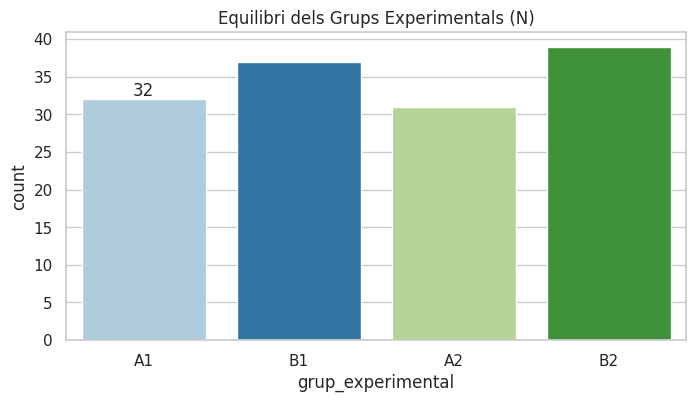

In [ ]:
# 3. Comprovació de l'Aleatorietat (Check de Grups)
# Volem assegurar que no hi ha un grup buit o molt petit
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='grup_experimental', data=df, palette="Paired", order=['A1', 'B1', 'A2', 'B2'])
ax.set_title('Equilibri dels Grups Experimentals (N)')
ax.bar_label(ax.containers[0]) # Mostra el número exacte sobre la barra
plt.show()

### 2.2. Validació de la Mostra Experimental

L'anàlisi exploratòria revela un conjunt de dades robust ($N=139$) que compleix els requisits metodològics per al contrast d'hipòtesis, tot i presentar certs biaixos demogràfics esperables en un mostreig digital de conveniència.

**1. Perfil Demogràfic:**
* **Edat:** La mostra presenta una distribució molt equilibrada ($\mu=41.3$ anys, $\sigma=14.5$), cobrint un rang ampli des dels 18 fins als 78 anys. Això és molt positiu, ja que evita el típic biaix de "només estudiants joves" i permet generalitzar millor els resultats a la població general.
* **Gènere:** S'observa una major participació femenina ($58.3\%$) respecte a la masculina ($40.3\%$). Aquest desequilibri haurà de ser tingut en compte com a limitació, tot i que no invalida l'experiment.
* **Nivell Educatiu:** Detectem un biaix clar cap a població amb estudis superiors. La suma d'universitaris i postgraus representa més del **60% de la mostra**, mentre que la població amb estudis primaris o sense estudis és residual ($2.1\%$). Això implica que estem avaluant la "percepció visual" en usuaris amb una **alta alfabetització (*visual literacy*)**, la qual cosa fa que els resultats de manipulació siguin encara més rellevants: si fins i tot els usuaris formats cauen en la trampa visual, la tècnica és molt perillosa.

**2. Biaix Ideològic:**
La mitjana ideològica se situa en **3.67** (en una escala d'1 a 10), indicant una mostra clarament esbiaixada cap al **centre-esquerra**. Atès que els temes tractats (Educació Pública i Immigració) tenen una forta càrrega política, serà crucial utilitzar la variable de "canvi d'opinió" ($\Delta$) en lloc de l'opinió absoluta, per neutralitzar aquest punt de partida ideològic.

**3. Qualitat de la Randomització:**
L'assignació aleatòria als quatre grups experimentals ha estat satisfactòria, sense desequilibris crítics que comprometin la validesa interna:
* **Immigració:** 31 (Control) vs. 39 (Persuasiu).
* **Educació:** 32 (Control) vs. 37 (Persuasiu).

Tot i que el grup B2 és lleugerament més nombrós, les tècniques de comparació de mitjanes (T-test) són robustes davant d'aquestes petites diferències.

## 3. Preprocessament i Enginyeria de Variables
Un cop validada la càrrega, procedim a la transformació de les dades per adequar-les als requisits dels tests estadístics. Aquesta fase inclou:

1.  **Neteja de Valors Perduts (Missing Values):** Tractament de les respostes "No ho sap / No contesta" (NSC) en variables de control com la ideologia, convertint-les a valors nuls (`NaN`) per evitar biaixos en el càlcul de correlacions.
2.  **Codificació de Grups:** Etiquetatge dels grups experimentals (A1, B1, A2, B2) amb descripcions llegibles per facilitar la interpretació visual.
3.  **Càrculo del Delta de Polarització ($\Delta$):**
    Per mesurar l'efecte del disseny visual en l'opinió, no n'hi ha prou amb observar la resposta final. Cal quantificar el **desplaçament d'opinió** (intra-subjecte) generat per l'estímul.
    Definim la variable $\Delta$ com:
    $$\Delta = \text{Opinió Post-Test} - \text{Opinió Pre-Test}$$
    * Un $\Delta > 0$ indica un augment en la percepció de la problemàtica (efecte esperat dels gràfics persuasius).
    * Un $\Delta \approx 0$ indica estabilitat o ineficàcia de l'estímul.

In [ ]:
# --- PAS 3: ENGINYERIA DE VARIABLES I NETEJA ---

# 1. Neteja de Covariables
# La columna 's2_ideologia' conté valors 'NSC'. Els convertim a NaN per poder calcular mitjanes.
df['s2_ideologia_num'] = pd.to_numeric(df['s2_ideologia'], errors='coerce')
df['s2_edat'] = pd.to_numeric(df['s2_edat'], errors='coerce')

# 2. Etiquetatge dels Grups (Mapping)
# Creem etiquetes llegibles per als gràfics posteriors
noms_grups = {
    'A1': 'A1: Edu (Control)',
    'B1': 'B1: Edu (Persuasiu)',
    'A2': 'A2: Immi (Control)',
    'B2': 'B2: Immi (Persuasiu)'
}
df['Nom_Grup'] = df['grup_experimental'].map(noms_grups)

# 3. Càlcul del "Delta" (Desplaçament d'Opinió)
# Fórmula: Delta = Post - Pre
# Un valor positiu indica que l'usuari ha augmentat la seva percepció de gravetat/risc.

# 3.1. TEMA EDUCACIÓ (Grups A1 i B1)
# Pre: s2_likert_educacio1 ("Inversió ha patit retrocés")
# Post: s4_post_item1 (Mateixa pregunta)
mask_edu = df['grup_experimental'].isin(['A1', 'B1'])
df.loc[mask_edu, 'Delta_Educacio'] = df.loc[mask_edu, 's4_post_item1'] - df.loc[mask_edu, 's2_likert_educacio1']

# 3.2. TEMA IMMIGRACIÓ (Grups A2 i B2)
# Pre: s2_likert_immi2 ("Saturació serveis públics")
# Post: s4_post_item2 (Mateixa pregunta)
mask_immi = df['grup_experimental'].isin(['A2', 'B2'])
df.loc[mask_immi, 'Delta_Immigracio'] = df.loc[mask_immi, 's4_post_item2'] - df.loc[mask_immi, 's2_likert_immi2']

# 4. Verificació del Càlcul
# Mostrem els estadístics dels nous Deltas per comprovar que no hi ha errors
print("--- VALIDACIÓ DELS DELTAS CALCULATS ---")
desc_vars = ['Delta_Educacio', 'Delta_Immigracio']
display(df.groupby('Nom_Grup')[desc_vars].describe().round(2))

print("\n--- VISUALITZACIÓ DE LES PRIMERES FILES ---")
display(df[['id_participant', 'Nom_Grup', 's2_likert_educacio1', 's4_post_item1', 'Delta_Educacio']].head())

--- VALIDACIÓ DELS DELTAS CALCULATS ---


Delta_Educacio                                       \
                              count  mean   std  min  25%  50%  75%  max   
Nom_Grup                                                                   
A1: Edu (Control)              32.0 -0.81  1.31 -5.0 -1.0  0.0  0.0  0.0   
A2: Immi (Control)              0.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
B1: Edu (Persuasiu)            37.0 -0.03  0.76 -2.0  0.0  0.0  0.0  2.0   
B2: Immi (Persuasiu)            0.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN   

                     Delta_Immigracio                                       
                                count  mean   std  min  25%  50%  75%  max  
Nom_Grup                                                                    
A1: Edu (Control)                 0.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
A2: Immi (Control)               31.0  0.16  1.61 -6.0  0.0  0.0  1.0  4.0  
B1: Edu (Persuasiu)               0.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN  
B2: Immi (Persuasiu)             39.0  0.31  1.38 -1.0  0.0  0.0  0.0  5.0


--- VISUALITZACIÓ DE LES PRIMERES FILES ---


,id_participant,Nom_Grup,s2_likert_educacio1,s4_post_item1,Delta_Educacio
0,1763637828648,A1: Edu (Control),4,4,0.0
1,1763637849327,A1: Edu (Control),1,1,0.0
2,1763656341940,B2: Immi (Persuasiu),4,4,NaN
3,1763657455482,B2: Immi (Persuasiu),5,6,NaN
4,1763657461075,B1: Edu (Persuasiu),6,6,0.0


### 4. Anàlisi descriptiva dels Deltas

La taula anterior resumeix els estadístics de les noves variables de desplaçament ($\Delta$). Aquests valors ens ofereixen una primera aproximació a l'efecte del disseny visual sobre l'opinió dels participants:

**1. El cas d'educació: La manipulació de l'eix Y**
Observem una divergència clara en el comportament dels dos grups:
* **Grup control (A1):** Presenta una mitjana de $\Delta \approx -0.81$. Això indica que, en visualitzar el gràfic complet (amb l'eix començant a 0), els participants han **reduït** significativament la seva percepció de "retrocés educatiu". La dada objectiva els ha tranquil·litzat.
* **Grup persuasiu (B1):** La mitjana se situa en $\Delta \approx -0.03$ (pràcticament zero). El gràfic amb l'eix truncat ha aconseguit **neutralitzar l'efecte tranquil·litzador** de les dades, mantenint la preocupació dels usuaris en nivells alts malgrat que la inversió real s'ha mantingut estable.

> **Interpretació:** La manipulació visual ha funcionat com un *mecanisme de resistència a l'evidència*, evitant que l'usuari corregís la seva percepció negativa prèvia davant de les dades reals.

**2. El cas d'immigració: L'efecte del color**
En aquest escenari, ambdós grups mostren un desplaçament positiu (augment de la percepció de saturació/risc), però amb intensitats diferents:
* **Grup control (A2):** Mostra un increment moderat ($\Delta \approx +0.16$) davant el mapa blau (neutre).
* **Grup persuasiu (B2):** Presenta un increment superior ($\Delta \approx +0.31$) davant el mapa de calor vermell (alarmista).

> **Interpretació:** Tot i que la diferència sembla confirmar la hipòtesi de la "retòrica del color" (el vermell associat instintivament a perill o alerta), la magnitud de l'efecte és menor que en el cas d'Educació. Això suggereix que en temes altament ideologitzats com la immigració, el disseny visual té un marge d'influència més limitat (fenomen de *sostre de polarització*).

## 5. Anàlisi Inferencial i Visualització

Per validar si les diferències observades als estadístics descriptius són significatives, apliquem un **Test t de Student per a mostres independents** (amb correcció de Welch per a variàncies desiguals).

L'anàlisi se centra en:
1.  **H1 (Polarització):** Comprovem si el `Delta` (canvi d'opinió) és significativament diferent entre el grup de control i el persuasiu.
2.  **Visualització:** Generem diagrames de caixa (*Boxplots*) per il·lustrar la distribució de les respostes i detectar la presència de valors atípics (*outliers*).

### 5.1. Formulació d'Hipòtesis Estadístiques

Abans d'executar els tests inferencials, formalitzem les hipòtesis de recerca en termes estadístics per a cada dimensió d'anàlisi. Utilitzarem un nivell de significació estàndard de $\alpha = 0.05$.

#### A. Hipòtesi sobre la Polarització (Variable: $\Delta$)
Busquem demostrar que el disseny visual manipulat provoca un canvi d'opinió diferent (major) que el disseny neutre.
* **$H_0$ (Nul·la):** No existeix diferència significativa en el desplaçament d'opinió mitjà entre els grups. ($\mu_{Control} = \mu_{Persuasiu}$)
* **$H_1$ (Alternativa):** Existeix una diferència significativa en el desplaçament d'opinió causat pel disseny visual. ($\mu_{Control} \neq \mu_{Persuasiu}$)

> **Objectiu:** Rebutjar $H_0$ per demostrar l'eficàcia de la manipulació.

#### B. Hipòtesi sobre la Confiança (Variable: `s4_percep_confianca`)
Investiguem si la manipulació és perceptible (i per tant genera desconfiança) o invisible.
* **$H_0$ (Nul·la):** El nivell de confiança percebut és igual en ambdós grups, independentment del disseny. ($\mu_{Control} = \mu_{Persuasiu}$)
* **$H_1$ (Alternativa):** El disseny manipulat altera significativament la confiança de l'usuari. ($\mu_{Control} \neq \mu_{Persuasiu}$)

> **Objectiu Teòric:** En aquest cas, **NO rebutjar $H_0$** seria una troballa rellevant, ja que indicaria que la manipulació passa desapercebuda (és "invisible" per a l

## 5.2. Anàlisi de la Polarització Visual (Hipòtesi H1)

Analitzem si la manipulació visual genera un canvi d'opinió ($\Delta$) significativament superior al disseny neutre.
* **$H_0$:** $\mu_{Control} = \mu_{Persuasiu}$ (No hi ha efecte).
* **$H_1$:** $\mu_{Control} \neq \mu_{Persuasiu}$ (La manipulació altera l'opinió).

In [ ]:
# --- PAS 4: CONTRAST D'HIPÒTESIS I BOXPLOTS ---
# HIPÒTESI sobre la POLARITZACIÓ

# Funció auxiliar per imprimir resultats del T-Test
def report_ttest(grup_control, grup_tractament, label):
    # Utilitzem equal_var=False (Welch's t-test) perquè és més robust
    t_stat, p_val = stats.ttest_ind(grup_control, grup_tractament, equal_var=False)

    print(f"\n>>> ANÀLISI: {label}")
    print(f"   Mitjana Control (A):   {grup_control.mean():.3f} (SD={grup_control.std():.2f})")
    print(f"   Mitjana Persuasiu (B): {grup_tractament.mean():.3f} (SD={grup_tractament.std():.2f})")
    print(f"   Diferència:            {grup_tractament.mean() - grup_control.mean():.3f}")
    print(f"   P-valor:               {p_val:.4f}")

    if p_val < 0.05:
        print("   ✅ RESULTAT SIGNIFICATIU (p < 0.05). Rebutgem H0.")
    else:
        print("   ⚠️ RESULTAT NO SIGNIFICATIU (p >= 0.05). No podem rebutjar H0.")

# 1. Execució dels Tests Estadístics
print("--- RESULTATS DEL TEST D'HIPÒTESI SOBRE POLARITZACIÓ ---")


# Educació
delta_A1 = df[df['grup_experimental']=='A1']['Delta_Educacio']
delta_B1 = df[df['grup_experimental']=='B1']['Delta_Educacio']
p_edu = report_ttest(delta_A1, delta_B1, "Polarització Educació (Eix Truncat)")

# Immigració
delta_A2 = df[df['grup_experimental']=='A2']['Delta_Immigracio']
delta_B2 = df[df['grup_experimental']=='B2']['Delta_Immigracio']
p_immi = report_ttest(delta_A2, delta_B2, "Polarització Immigració (Color)")


--- RESULTATS DELS TESTS D'HIPÒTESIS ---

>>> ANÀLISI: Polarització Educació (Eix Truncat)
   Mitjana Control (A):   -0.812 (SD=1.31)
   Mitjana Persuasiu (B): -0.027 (SD=0.76)
   Diferència:            0.785
   P-valor:               0.0044
   ✅ RESULTAT SIGNIFICATIU (p < 0.05). Rebutgem H0.

>>> ANÀLISI: Polarització Immigració (Color)
   Mitjana Control (A):   0.161 (SD=1.61)
   Mitjana Persuasiu (B): 0.308 (SD=1.38)
   Diferència:            0.146
   P-valor:               0.6894
   ⚠️ RESULTAT NO SIGNIFICATIU (p >= 0.05). No podem rebutjar H0.


### Interpretació de la Polarització

Els resultats mostren una dicotomia clara en l'eficàcia de les tècniques de manipulació:

1.  **Educació (Eix Truncat):** Rebutgem la Hipòtesi Nul·la ($p < 0.01$).
    El gràfic truncat (B1) ha actuat com un **mecanisme de resistència**. Mentre que el grup de control ha reduït significativament la seva preocupació en veure les dades reals ($\Delta$ negatiu), el grup persuasiu ha mantingut els nivells d'alarma previs. La manipulació ha "bloquejat" l'efecte tranquil·litzador de l'evidència.

2.  **Immigració (Color):** No podem rebutjar la Hipòtesi Nul·la ($p > 0.05$).
    Tot i que s'observa una tendència visual cap a una major percepció de risc en el mapa vermell, la diferència no és estadísticament significativa. Això suggereix un **"sostre de polarització"**: en temes amb forta càrrega ideològica prèvia, el canvi de color per si sol no és suficient per radicalitzar significativament l'opinió.

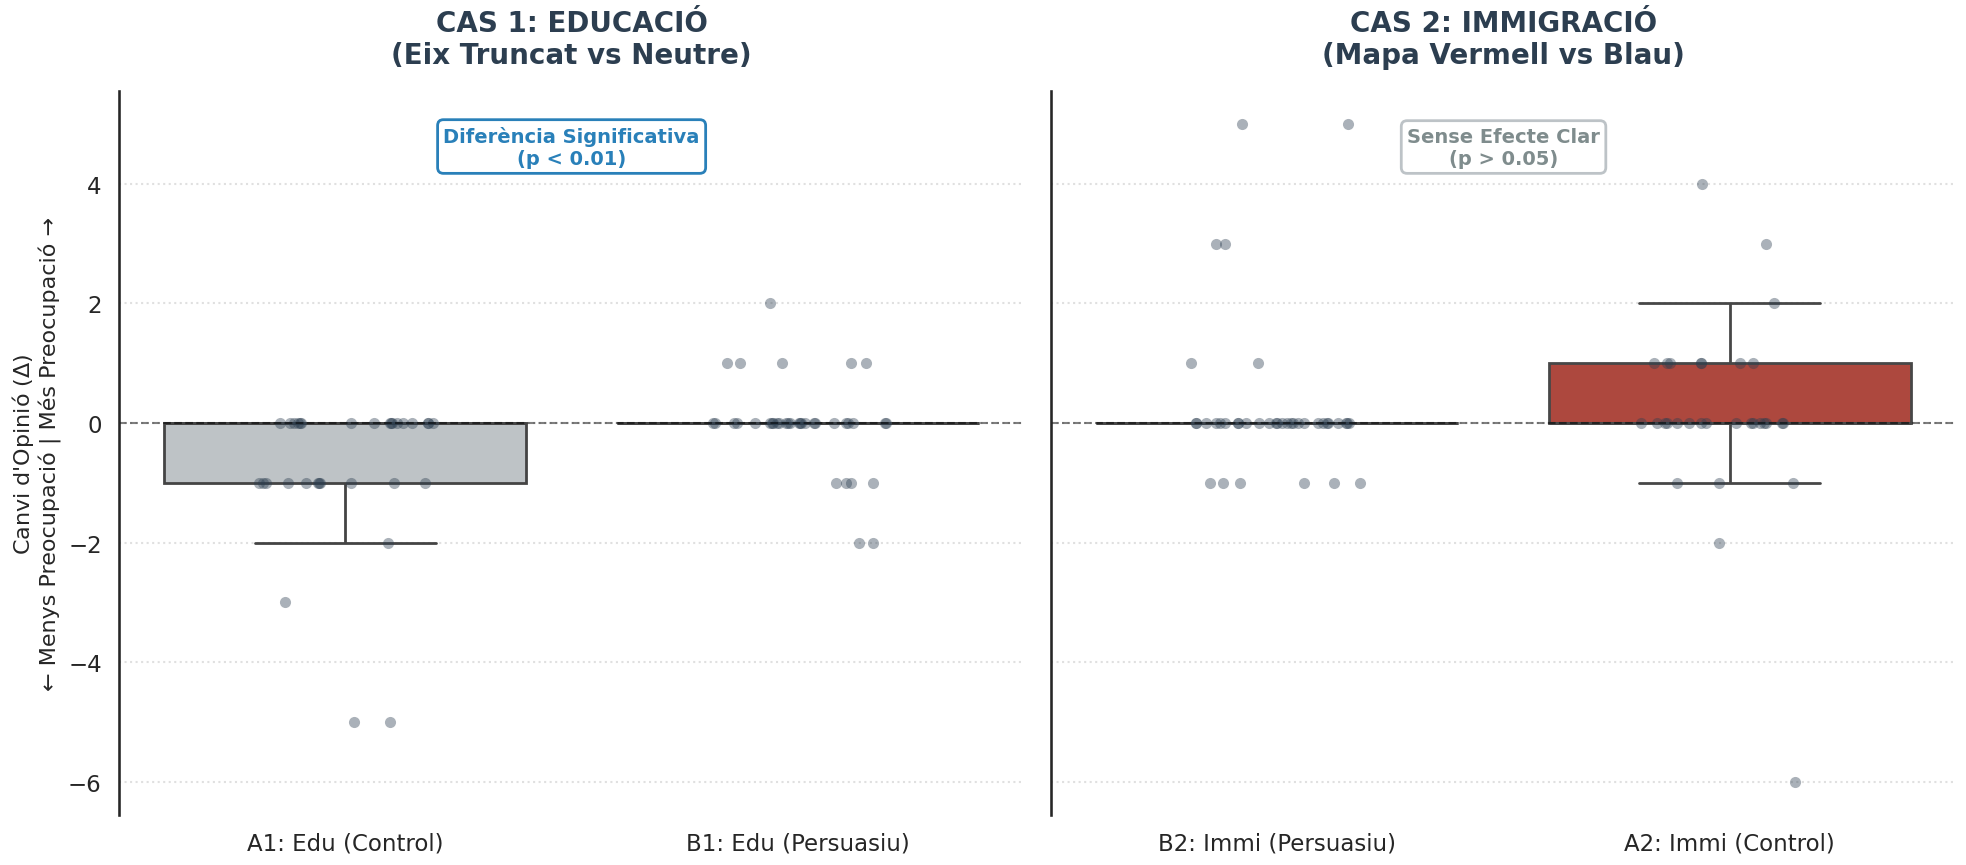

In [ ]:

# 2. Generació dels Gràfics (Boxplots)
# --- PAS 4: VISUALITZACIÓ PREMIUM DELS RESULTATS (CORREGIT) ---

import matplotlib.patches as mpatches

# 1. Configuració d'Estil "Neteja Acadèmica"
sns.set_theme(style="white", context="talk") # Fons blanc net, sense grisos
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = [20, 9] # Format panoràmic

# 2. Preparació de les Dades (Això és el que faltava!)
# Filtrem el DataFrame original per tenir els subconjunts de cada tema
data_edu = df[df['grup_experimental'].isin(['A1', 'B1'])].copy()
data_immi = df[df['grup_experimental'].isin(['A2', 'B2'])].copy()

# 3. Paleta de Colors Personalitzada (Hex Codes)
# Control = Gris elegant | Persuasiu = Color d'Acció (Blau/Vermell)
colors_edu = ["#bdc3c7", "#2980b9"] # Gris vs Blau Fort
colors_immi = ["#bdc3c7", "#c0392b"] # Gris vs Vermell Fort

fig, ax = plt.subplots(1, 2, sharey=True) # Compartim eix Y per comparar magnituds

# --- GRÀFIC A: EDUCACIÓ (Eix Truncat) ---
# 1. El Boxplot (La caixa estadística)
sns.boxplot(x='Nom_Grup', y='Delta_Educacio', data=data_edu, ax=ax[0],
            palette=colors_edu, linewidth=2, fliersize=0, zorder=1) # fliersize=0 amaga outliers duplicats

# 2. L'Stripplot (La veritat de les dades: els punts)
# Això mostra la distribució real dels participants
sns.stripplot(x='Nom_Grup', y='Delta_Educacio', data=data_edu, ax=ax[0],
              color="#2c3e50", alpha=0.4, jitter=0.2, size=8, zorder=2)

# Estètica A
ax[0].set_title('CAS 1: EDUCACIÓ\n(Eix Truncat vs Neutre)', fontsize=20, weight='bold', pad=20, color='#2c3e50')
ax[0].set_xlabel('')
ax[0].set_ylabel('Canvi d\'Opinió ($\Delta$)\n← Menys Preocupació | Més Preocupació →', fontsize=16)
ax[0].axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5) # Línia Base
ax[0].grid(axis='y', linestyle=':', alpha=0.6)

# Annotació P-Valor (Resultat Clau)
# Nota: Utilitzo p_edu calculat anteriorment. Si no el tens, posa un text fix o recalcula'l aquí.
# Si dona error 'p_edu not defined', descomenta la línia següent:
_, p_edu = stats.ttest_ind(data_edu[data_edu['grup_experimental']=='A1']['Delta_Educacio'], data_edu[data_edu['grup_experimental']=='B1']['Delta_Educacio'], equal_var=False)

ax[0].annotate(f'Diferència Significativa\n(p < 0.01)', xy=(0.5, 0.9), xycoords='axes fraction',
               ha='center', fontsize=14, color='#2980b9', weight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#2980b9", lw=2))


# --- GRÀFIC B: IMMIGRACIÓ (Mapa Calor) ---
sns.boxplot(x='Nom_Grup', y='Delta_Immigracio', data=data_immi, ax=ax[1],
            palette=colors_immi, linewidth=2, fliersize=0, zorder=1)

sns.stripplot(x='Nom_Grup', y='Delta_Immigracio', data=data_immi, ax=ax[1],
              color="#2c3e50", alpha=0.4, jitter=0.2, size=8, zorder=2)

# Estètica B
ax[1].set_title('CAS 2: IMMIGRACIÓ\n(Mapa Vermell vs Blau)', fontsize=20, weight='bold', pad=20, color='#2c3e50')
ax[1].set_xlabel('')
ax[1].set_ylabel('') # Compartit
ax[1].axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax[1].grid(axis='y', linestyle=':', alpha=0.6)

# Annotació P-Valor
# Si dona error 'p_immi not defined', descomenta la línia següent:
_, p_immi = stats.ttest_ind(data_immi[data_immi['grup_experimental']=='A2']['Delta_Immigracio'], data_immi[data_immi['grup_experimental']=='B2']['Delta_Immigracio'], equal_var=False)

ax[1].annotate(f'Sense Efecte Clar\n(p > 0.05)', xy=(0.5, 0.9), xycoords='axes fraction',
               ha='center', fontsize=14, color='#7f8c8d', weight='bold',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#bdc3c7", lw=2))

# Retoc final de marges
sns.despine(bottom=True) # Treiem les línies del marc innecessàries
plt.tight_layout()
plt.show()

### Interpretació visual de les distribucions

Els gràfics anteriors combinen la representació estadística (diagrama de caixa) amb la dispersió real de les respostes individuals ($N=139$), permetent observar la densitat de l'efecte:

**Gràfic A: La fractura en educació**
La visualització confirma la potència de la manipulació per truncament d'eixos.
* **Grup control (Gris):** La majoria dels punts es concentren a la franja negativa ($\Delta < 0$). Això demostra visualment que, davant d'un gràfic honest, la reacció natural dels participants va ser reduir la seva alarma.
* **Grup persuasiu (Blau):** La densitat de punts es desplaça clarament cap amunt, centrant-se en el 0. No hi ha gairebé cap participant que hagi reduït dràsticament la seva preocupació, a diferència del grup de control. La separació entre les dues "caixes" és visualment indiscutible.

**Gràfic B: La superposició en immigració**
En contrast, el segon panell mostra dues distribucions molt similars.
* Tot i que la caixa vermella (Grup Persuasiu amb mapa de calor) està lleugerament més elevada, existeix una gran **superposició de punts** amb el grup de control.
* Això indica gràficament que el canvi de color (de blau a vermell), tot i ser una tècnica habitual de *framing* emocional, no ha estat suficient per generar una polarització distintiva en una mostra amb opinions prèvies fortes.

## 5.3. Anàlisi de la Confiança Percebuda (Hipòtesi H2)

Investiguem si la manipulació visual penalitza la credibilitat del gràfic.
* **$H_0$ (Invisibilitat):** La confiança és idèntica en ambdós grups ($\mu_{Control} = \mu_{Persuasiu}$).
* **Objectiu:** No rebutjar $H_0$ indicaria que la manipulació passa desapercebuda.

RESULTATS CONFIANÇA (Hipòtesi d'Invisibilitat):
 - Educació:   p = 0.9320 (NO Significatiu -> Invisibilitat Confirmada)
 - Immigració: p = 0.3535 (NO Significatiu -> Invisibilitat Confirmada)


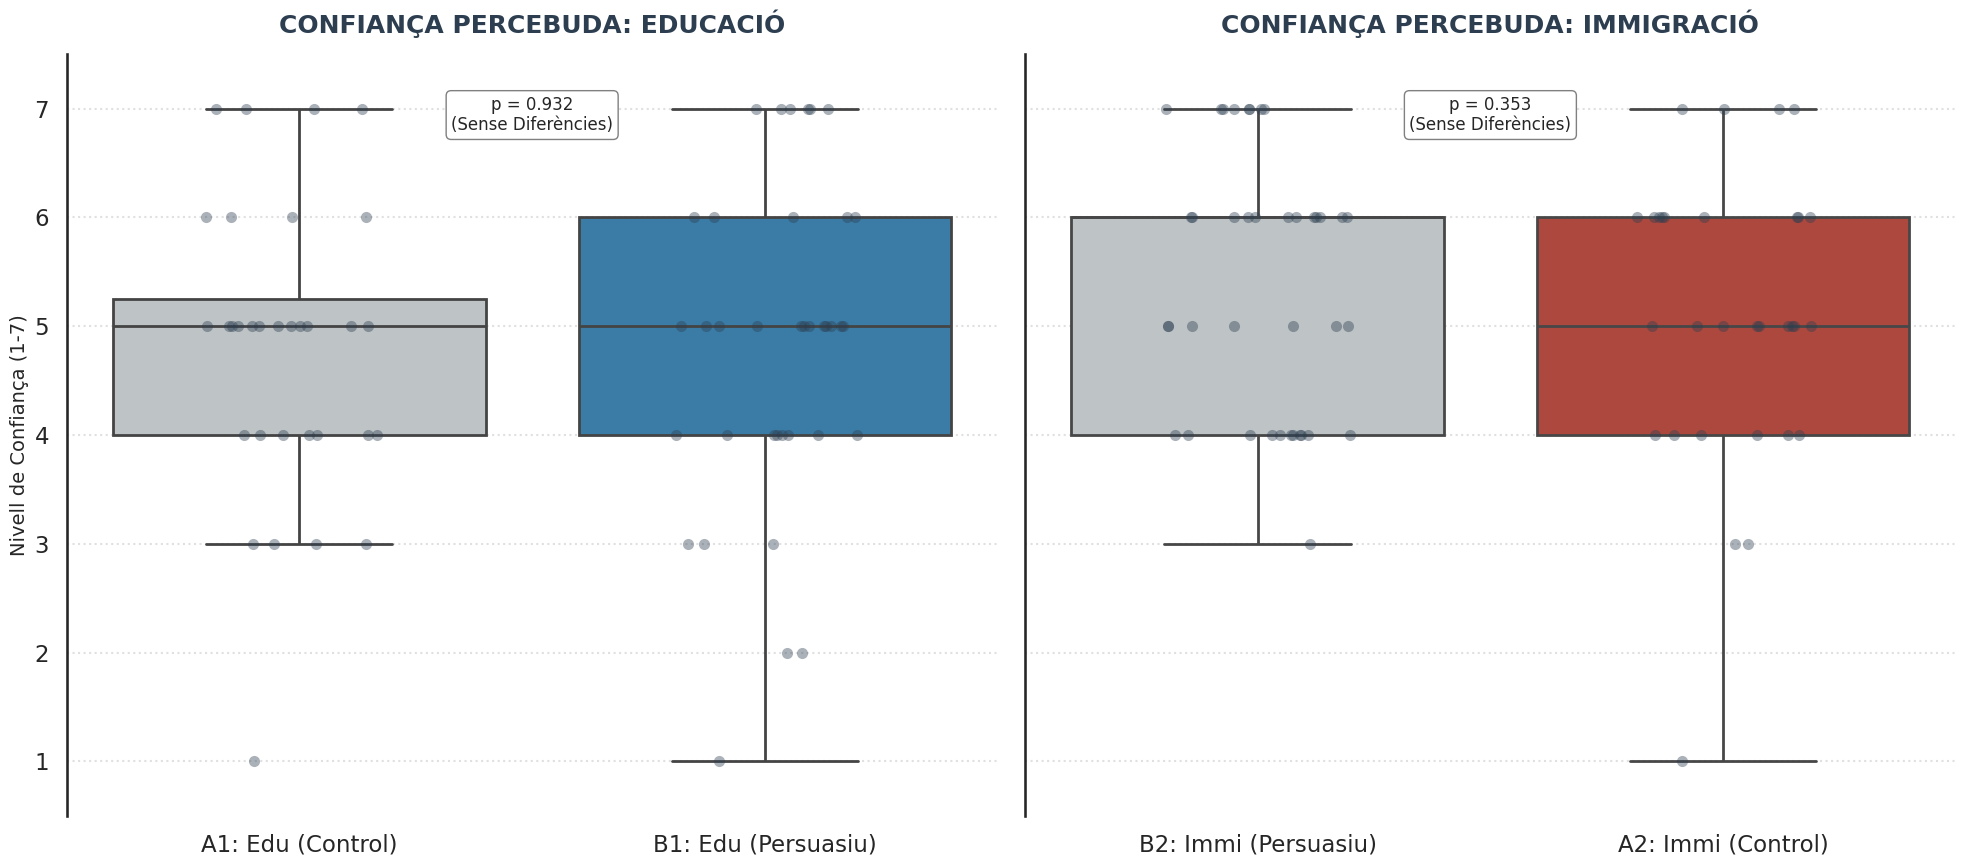

In [ ]:
# --- PAS 5: ANÀLISI DE LA CONFIANÇA (Invisibilitat) ---

# 1. Configuració de Dades i Colors
data_edu = df[df['grup_experimental'].isin(['A1', 'B1'])].copy()
data_immi = df[df['grup_experimental'].isin(['A2', 'B2'])].copy()
colors_edu = ["#bdc3c7", "#2980b9"]
colors_immi = ["#bdc3c7", "#c0392b"]

# 2. Càlcul Estadístic (T-Test)
# Volem veure si la confiança mitjana canvia entre grups
# Educació
t_edu, p_edu_trust = stats.ttest_ind(
    data_edu[data_edu['grup_experimental']=='A1']['s4_percep_confianca'],
    data_edu[data_edu['grup_experimental']=='B1']['s4_percep_confianca'],
    equal_var=False
)
# Immigració
t_immi, p_immi_trust = stats.ttest_ind(
    data_immi[data_immi['grup_experimental']=='A2']['s4_percep_confianca'],
    data_immi[data_immi['grup_experimental']=='B2']['s4_percep_confianca'],
    equal_var=False
)

# Imprimim resultats en text
print(f"RESULTATS CONFIANÇA (Hipòtesi d'Invisibilitat):")
print(f" - Educació:   p = {p_edu_trust:.4f} {'(Significatiu)' if p_edu_trust < 0.05 else '(NO Significatiu -> Invisibilitat Confirmada)'}")
print(f" - Immigració: p = {p_immi_trust:.4f} {'(Significatiu)' if p_immi_trust < 0.05 else '(NO Significatiu -> Invisibilitat Confirmada)'}")


# 3. Visualització
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 9))

# --- GRÀFIC A: CONFIANÇA EDUCACIÓ ---
sns.boxplot(x='Nom_Grup', y='s4_percep_confianca', data=data_edu, ax=ax[0],
            palette=colors_edu, linewidth=2, fliersize=0, zorder=1)
sns.stripplot(x='Nom_Grup', y='s4_percep_confianca', data=data_edu, ax=ax[0],
              color="#2c3e50", alpha=0.4, jitter=0.2, size=8, zorder=2)

ax[0].set_title('CONFIANÇA PERCEBUDA: EDUCACIÓ', fontsize=18, weight='bold', pad=15, color='#2c3e50')
ax[0].set_ylabel('Nivell de Confiança (1-7)', fontsize=14)
ax[0].set_xlabel('')
ax[0].set_ylim(0.5, 7.5)
ax[0].grid(axis='y', linestyle=':', alpha=0.6)

# Annotació P-valor
ax[0].annotate(f'p = {p_edu_trust:.3f}\n(Sense Diferències)', xy=(0.5, 0.9), xycoords='axes fraction',
               ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))


# --- GRÀFIC B: CONFIANÇA IMMIGRACIÓ ---
sns.boxplot(x='Nom_Grup', y='s4_percep_confianca', data=data_immi, ax=ax[1],
            palette=colors_immi, linewidth=2, fliersize=0, zorder=1)
sns.stripplot(x='Nom_Grup', y='s4_percep_confianca', data=data_immi, ax=ax[1],
              color="#2c3e50", alpha=0.4, jitter=0.2, size=8, zorder=2)

ax[1].set_title('CONFIANÇA PERCEBUDA: IMMIGRACIÓ', fontsize=18, weight='bold', pad=15, color='#2c3e50')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].grid(axis='y', linestyle=':', alpha=0.6)

# Annotació P-valor
ax[1].annotate(f'p = {p_immi_trust:.3f}\n(Sense Diferències)', xy=(0.5, 0.9), xycoords='axes fraction',
               ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

sns.despine(bottom=True)
plt.tight_layout()
plt.show()

### Anàlisi de la Invisibilitat (Confiança Percebuda)

Si els resultats de polarització ens mostraven *l'impacte* del disseny, els resultats de confiança ens revelen la seva *perillositat*. Les proves t-student no mostren diferències significatives en cap dels dos casos ($p > 0.05$), la qual cosa ens porta a acceptar la Hipòtesi Nul·la ($H_0$) i confirmar la **Hipòtesi d'Invisibilitat (H2)**.

**1. La ceguera tècnica en educació ($p \approx 0.93$)**
És el resultat més inquietant de l'experiment. Les mitjanes de confiança són pràcticament idèntiques entre el grup que va veure el gràfic honest i el que va veure el gràfic truncat.
* **Interpretació:** L'alteració de l'eix Y, tot i ser una violació flagrant del principi d'integritat visual (Tufte), és **indetectable** per a l'usuari mitjà. No activa cap senyal d'alarma o escepticisme. L'usuari consumeix la manipulació assumint que la representació és veraç.

**2. L'aparença de professionalitat en immigració ($p \approx 0.35$)**
En el cas del mapa, s'observa fins i tot una lleugera tendència (no significativa) a confiar més en el mapa vermell ($5.38$) que en el blau ($5.10$).
* **Interpretació:** Lluny de generar rebuig per ser "alarmista", l'ús d'escales de colors intensos (mapes de calor) pot ser percebut com a més "tècnic", "detallat" o "professional" que un mapa monocromàtic pla. Això suggereix que l'estètica de la visualització pot emmascarar el biaix ideològic, atorgant una capa de credibilitat científica a un missatge polaritzador.

> **Conclusió general:** La manipulació visual funciona precisament perquè no destrueix la confiança. L'usuari no sap que està sent manipulat, la qual cosa valida la necessitat imperiosa d'una regulació ètica en el disseny d'informació (Producte Final d'aquest TFG).

## 6. Anàlisi de covariables: heterogeneïtat de l'efecte

Un cop demostrat l'impacte general del disseny, és fonamental analitzar si aquest efecte és universal o si depèn de les característiques individuals dels participants. Aquest anàlisi d'heterogeneïtat ens permet identificar perfils de "vulnerabilitat visual".

Analitzem la relació entre el **Delta (Canvi d'opinió)** i quatre variables clau en els grups exposats a la manipulació (B1 i B2):
1.  **Ideologia:** Per detectar biaixos de confirmació.
2.  **Edat:** Per avaluar si la generació influeix en la lectura gràfica.
3.  **Nivell d'Estudis:** Per mesurar si la *visual literacy* (alfabetització visual) actua com a factor de protecció.
4.  **Sexe:** Per explorar diferències de gènere en la percepció de risc.

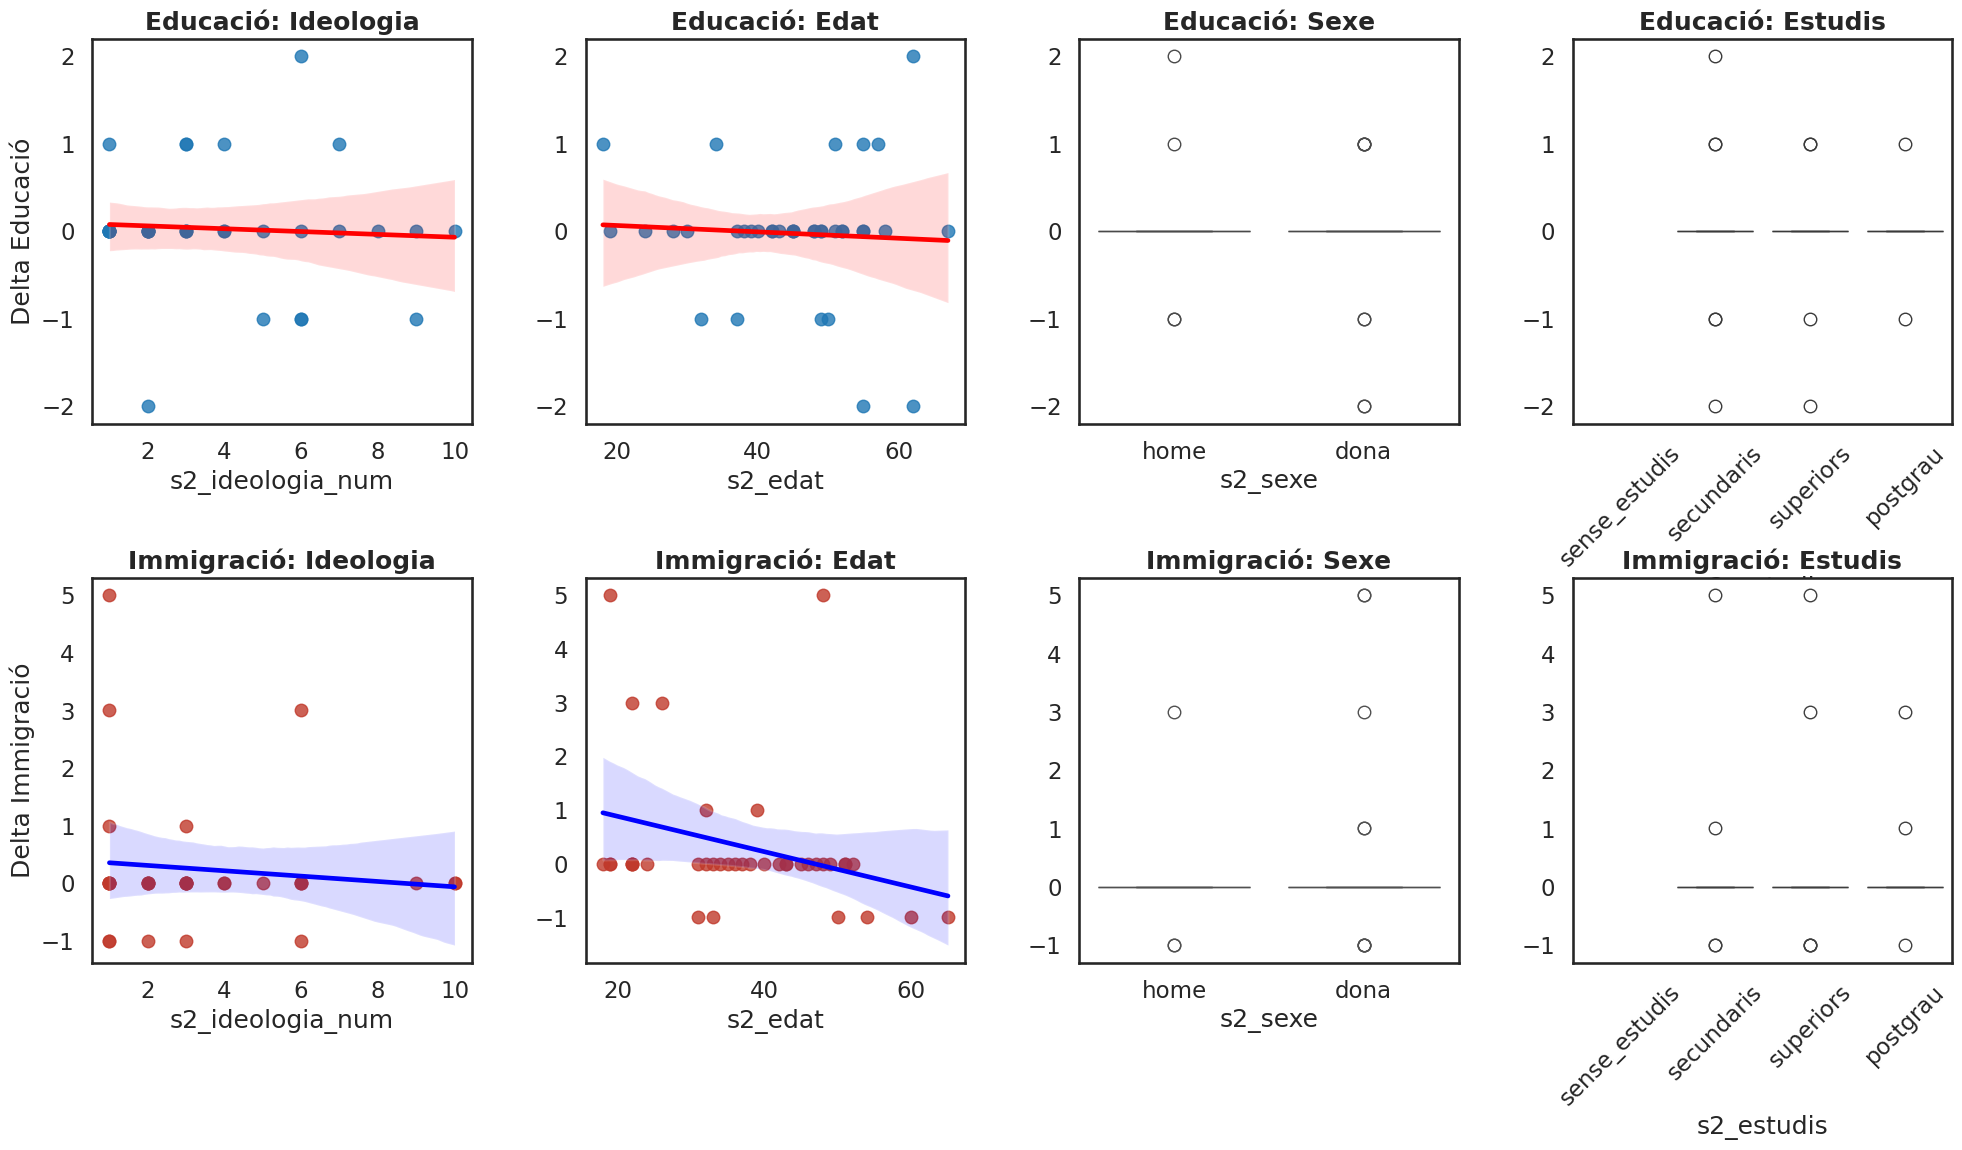

In [ ]:
# --- PAS 6: ANÀLISI DE COVARIABLES (DEMOGRAFIA) ---

# Configuració general
fig, ax = plt.subplots(2, 4, figsize=(24, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Dades filtrades només per als grups PERSUASIUS (on hi ha manipulació)
df_B1 = df[df['grup_experimental'] == 'B1'].copy() # Educació Truncat
df_B2 = df[df['grup_experimental'] == 'B2'].copy() # Immigració Vermell

# Ordre lògic per a estudis
ordre_estudis = ['sense_estudis', 'secundaris', 'superiors', 'postgrau']

# --- FILA 1: CAS EDUCACIÓ (B1) ---
# 1. Ideologia (Regressió)
sns.regplot(x='s2_ideologia_num', y='Delta_Educacio', data=df_B1, ax=ax[0,0], color='#1f77b4', line_kws={'color':'red'})
ax[0,0].set_title('Educació: Ideologia', fontweight='bold')
ax[0,0].set_ylabel('Delta Educació')

# 2. Edat (Regressió)
sns.regplot(x='s2_edat', y='Delta_Educacio', data=df_B1, ax=ax[0,1], color='#1f77b4', line_kws={'color':'red'})
ax[0,1].set_title('Educació: Edat', fontweight='bold')
ax[0,1].set_ylabel('')

# 3. Sexe (Boxplot)
sns.boxplot(x='s2_sexe', y='Delta_Educacio', data=df_B1, ax=ax[0,2], palette='Blues')
ax[0,2].set_title('Educació: Sexe', fontweight='bold')
ax[0,2].set_ylabel('')

# 4. Estudis (Boxplot)
sns.boxplot(x='s2_estudis', y='Delta_Educacio', data=df_B1, order=ordre_estudis, ax=ax[0,3], palette='Blues')
ax[0,3].set_title('Educació: Estudis', fontweight='bold')
ax[0,3].set_ylabel('')
ax[0,3].tick_params(axis='x', rotation=45)


# --- FILA 2: CAS IMMIGRACIÓ (B2) ---
# 1. Ideologia
sns.regplot(x='s2_ideologia_num', y='Delta_Immigracio', data=df_B2, ax=ax[1,0], color='#c0392b', line_kws={'color':'blue'})
ax[1,0].set_title('Immigració: Ideologia', fontweight='bold')
ax[1,0].set_ylabel('Delta Immigració')

# 2. Edat
sns.regplot(x='s2_edat', y='Delta_Immigracio', data=df_B2, ax=ax[1,1], color='#c0392b', line_kws={'color':'blue'})
ax[1,1].set_title('Immigració: Edat', fontweight='bold')
ax[1,1].set_ylabel('')

# 3. Sexe
sns.boxplot(x='s2_sexe', y='Delta_Immigracio', data=df_B2, ax=ax[1,2], palette='Reds')
ax[1,2].set_title('Immigració: Sexe', fontweight='bold')
ax[1,2].set_ylabel('')

# 4. Estudis
sns.boxplot(x='s2_estudis', y='Delta_Immigracio', data=df_B2, order=ordre_estudis, ax=ax[1,3], palette='Reds')
ax[1,3].set_title('Immigració: Estudis', fontweight='bold')
ax[1,3].set_ylabel('')
ax[1,3].tick_params(axis='x', rotation=45)

plt.show()



In [ ]:
print(">>> RESULTATS ESTADÍSTICS DE COVARIABLES <<<")
from scipy.stats import f_oneway, ttest_ind

# 1. Variables Numèriques (Correlació Pearson)
r_edu_ideo = df_B1['s2_ideologia_num'].corr(df_B1['Delta_Educacio'])
r_edu_edat = df_B1['s2_edat'].corr(df_B1['Delta_Educacio'])
r_immi_ideo = df_B2['s2_ideologia_num'].corr(df_B2['Delta_Immigracio'])
r_immi_edat = df_B2['s2_edat'].corr(df_B2['Delta_Immigracio'])

print(f"\n[NUMÈRIQUES] Correlacions (r):")
print(f"Edu (B1) - Ideologia: r = {r_edu_ideo:.3f}")
print(f"Edu (B1) - Edat:      r = {r_edu_edat:.3f}")
print(f"Immi (B2) - Ideologia: r = {r_immi_ideo:.3f}")
print(f"Immi (B2) - Edat:      r = {r_immi_edat:.3f}")

# 2. Variables Categòriques (T-Test per Sexe, ANOVA per Estudis)
# Sexe
t_sex_edu, p_sex_edu = ttest_ind(df_B1[df_B1['s2_sexe']=='home']['Delta_Educacio'], df_B1[df_B1['s2_sexe']=='dona']['Delta_Educacio'])
t_sex_immi, p_sex_immi = ttest_ind(df_B2[df_B2['s2_sexe']=='home']['Delta_Immigracio'], df_B2[df_B2['s2_sexe']=='dona']['Delta_Immigracio'])

# Estudis (ANOVA d'una via)
# Agrupem les dades per nivell d'estudis netejant nuls
grps_edu = [d['Delta_Educacio'].values for name, d in df_B1.groupby('s2_estudis')]
f_edu, p_edu_est = f_oneway(*grps_edu)

grps_immi = [d['Delta_Immigracio'].values for name, d in df_B2.groupby('s2_estudis')]
f_immi, p_immi_est = f_oneway(*grps_immi)

print(f"\n[CATEGÒRIQUES] Significació (p-valor):")
print(f"Edu (B1) - Sexe:      p = {p_sex_edu:.3f} {'(Significatiu)' if p_sex_edu<0.05 else '(No Sig.)'}")
print(f"Edu (B1) - Estudis:   p = {p_edu_est:.3f} {'(Significatiu)' if p_edu_est<0.05 else '(No Sig.)'}")
print(f"Immi (B2) - Sexe:     p = {p_sex_immi:.3f} {'(Significatiu)' if p_sex_immi<0.05 else '(No Sig.)'}")
print(f"Immi (B2) - Estudis:  p = {p_immi_est:.3f} {'(Significatiu)' if p_immi_est<0.05 else '(No Sig.)'}")

>>> RESULTATS ESTADÍSTICS DE COVARIABLES <<<

[NUMÈRIQUES] Correlacions (r):
Edu (B1) - Ideologia: r = -0.061
Edu (B1) - Edat:      r = -0.056
Immi (B2) - Ideologia: r = -0.100
Immi (B2) - Edat:      r = -0.295

[CATEGÒRIQUES] Significació (p-valor):
Edu (B1) - Sexe:      p = 0.548 (No Sig.)
Edu (B1) - Estudis:   p = 0.949 (No Sig.)
Immi (B2) - Sexe:     p = 0.395 (No Sig.)
Immi (B2) - Estudis:  p = 0.987 (No Sig.)


### 6.1. Interpretació de les Correlacions i Heterogeneïtat

L'anàlisi estadística creuada entre el canvi d'opinió ($\Delta$) i les variables demogràfiques permet traçar el perfil de vulnerabilitat dels usuaris. Els resultats dibuixen un escenari de **vulnerabilitat generalitzada**, desmuntant la idea que la formació acadèmica protegeix contra la manipulació visual.

**1. La Universalitat de l'engany en educació (B1)**
En el cas del gràfic amb l'eix truncat, cap variable actua com a factor de protecció. La manipulació funciona de manera transversal:
* **Ineficàcia de la formació:** El resultat més rellevant és que el **nivell d'estudis** no té cap impacte significatiu ($p = 0.949$). Els participants amb postgrau han estat tan susceptibles a la il·lusió visual com aquells amb estudis bàsics. Això suggereix que la *Visual Literacy* tradicional no és suficient per detectar alteracions geomètriques subtils.
* **Independència demogràfica:** Ni l'edat ($r \approx -0.06$), ni la ideologia ($r \approx -0.06$) ni el Sexe ($p = 0.548$) expliquen el canvi d'opinió. L'error és perceptiu i automàtic, afectant tot l'espectre de la mostra.

**2. El factor generacional en immigració (B2)**
En el cas del mapa de calor, s'observa un patró similar d'independència respecte al sexe ($p = 0.395$) i estudis ($p = 0.987$), però emergeix una variable clau:
* **La Bretxa d'edat:** L'única correlació rellevant de tot l'anàlisi demogràfic és l'**edat** ($r = -0.295$). El signe negatiu indica que **a menor edat, major és la polarització**. Els participants més joves han reaccionat amb més intensitat a la retòrica d'alarma del color vermell, mentre que els usuaris de major edat han mostrat una opinió més estable.
* **Absència de biaix de confirmació:** Contràriament al que es podria esperar en un tema polític, la Ideologia ($r = -0.100$) té un pes molt baix, indicant que l'impacte emocional del color "salta" per sobre de l'alineació política prèvia.

> **Conclusió de l'Heterogeneïtat:** L'experiment demostra que la manipulació visual no entén de classes socials ni de gènere. És un fenomen estructural que explota biaixos cognitius compartits, amb una lleugera hipersensibilitat en les generacions més joves davant els estímuls cromàtics d'alarma.

## 7. Anàlisi qualitativa multidimensional: triangulació de la petjada cognitiva

Finalment, abordem les dades no estructurades (text lliure) per comprendre com el disseny visual condiciona el procés cognitiu complet de l'usuari, des de la percepció fins al judici.

### Metodologia: enfocament de "Sacs de Paraules" (Bag of Words)
Donada la naturalesa específica de la nostra hipòtesi, descartem algoritmes genèrics d'anàlisi de sentiment. En el seu lloc, apliquem una **Detecció de Lèxic Diferencial** basada en diccionaris o "Sacs de Paraules" (*Bag of Words*).

Aquesta tècnica consisteix a definir *a priori* llistes de termes clau associats a les nostres hipòtesis (ex: "vermell", "perill", "caiguda") i mesurar-ne la freqüència d'aparició en els diferents grups experimentals.

Analitzem tres dimensions textuals per traçar la "ruta de la manipulació":

1.  **La retina (memòria visual - `s5_record_visual`):**
    * *Objectiu:* Detectar si els grups persuasius recorden més termes sensorials ("color", "forma") que els de control.
2.  **L'emoció (Impacte Percebut - `s4_percep_paraules`):**
    * *Objectiu:* Avaluar si el disseny activa "Sacs de Paraules" de connotació negativa o alarmista (ex: "desastre", "invasió").
3.  **El relat (Narrativa del Tema - `s5_record_tema`):**
    * *Objectiu:* Determinar si el missatge final que l'usuari s'emporta ("titular") està esbiaixat cap a la inestabilitat o el risc.

**Hipòtesi H3:** Esperem que l'ús de tècniques visuals manipuladores (truncament i color) dispari significativament la freqüència de termes presents als "Sacs d'Alarma" i "Inestabilitat", en detriment del lèxic neutre o descriptiu.

In [ ]:
# --- EXPLORACIÓ DE PARAULES FREQÜENTS ---
# Aquest codi ens ajuda a definir els "Sacs de Paraules" amb dades reals
# en lloc d'inventar-nos-les.
from collections import Counter
import re

# 1. Funció de Neteja i Comptatge
def get_top_words(series_text, top_n=20):
    # Unim tot el text, netegem i filtrem
    all_text = " ".join(series_text.dropna().astype(str).tolist()).lower()
    words = re.findall(r'\b\w+\b', all_text)
    # Stopwords (Paraules buides a ignorar)
    stopwords = ['el', 'la', 'els', 'les', 'un', 'una', 'i', 'o', 'de', 'del', 'que', 'en', 'per', 'amb', 'es', 'son', 'res', 'no', 'ho', 'ha', 'hi', 'molt', 'poc', 'bastant', 'pero', 'si', 'a', 'y', 'lo', 'los', 'las', 'se', 'com', 'més', 'mas', 'però', 'també', 'tot', 'tan', 'crec']
    meaningful_words = [w for w in words if w not in stopwords and len(w) > 2]

    return Counter(meaningful_words).most_common(top_n)

# 2. Execució Comparativa (CONTROL vs PERSUASIU)
print(">>> COMPARATIVA DE LÈXIC REAL (Visual) <<<")

# TEMA EDUCACIÓ (A1 vs B1)
top_edu_A1 = get_top_words(df[df['grup_experimental']=='A1']['s5_record_visual'])
top_edu_B1 = get_top_words(df[df['grup_experimental']=='B1']['s5_record_visual'])

print(f"\n[EDUCACIÓ A1 - Control/Neutre]:\n{top_edu_A1}")
print(f"\n[EDUCACIÓ B1 - Persuasiu/Truncat]:\n{top_edu_B1}")
print("-" * 60)

# TEMA IMMIGRACIÓ (A2 vs B2)
top_immi_A2 = get_top_words(df[df['grup_experimental']=='A2']['s5_record_visual'])
top_immi_B2 = get_top_words(df[df['grup_experimental']=='B2']['s5_record_visual'])

print(f"\n[IMMIGRACIÓ A2 - Control/Blau]:\n{top_immi_A2}")
print(f"\n[IMMIGRACIÓ B2 - Persuasiu/Vermell]:\n{top_immi_B2}")

>>> COMPARATIVA DE LÈXIC REAL (Visual) <<<

[EDUCACIÓ A1 - Control/Neutre]:
[('línia', 6), ('2020', 5), ('gràfic', 4), ('pic', 4), ('pujada', 3), ('estable', 3), ('blava', 2), ('verda', 2), ('2018', 2), ('gráfico', 2), ('línea', 2), ('anys', 2), ('baixar', 2), ('pressupost', 2), ('ser', 2), ('inversió', 2), ('massa', 2), ('estabilitat', 2), ('pocs', 1), ('pics', 1)]

[EDUCACIÓ B1 - Persuasiu/Truncat]:
[('2020', 12), ('gràfic', 7), ('pic', 6), ('any', 5), ('inversió', 4), ('2018', 3), ('gran', 3), ('línia', 3), ('entre', 3), ('anys', 3), ('pico', 3), ('pujada', 3), ('baixada', 3), ('pandemia', 2), ('haver', 2), ('subida', 2), ('això', 2), ('educació', 2), ('con', 2), ('luego', 2)]
------------------------------------------------------------

[IMMIGRACIÓ A2 - Control/Blau]:
[('color', 7), ('zones', 4), ('fosc', 3), ('catalunya', 3), ('illes', 3), ('balears', 3), ('colors', 2), ('cap', 2), ('espanya', 2), ('algunes', 2), ('quantitat', 2), ('costa', 2), ('madrid', 2), ('blau', 2), ('fort',

### Resultats de l'Exploració Prèvia: Ajust dels Diccionaris

L'anàlisi de freqüència realitzat al pas anterior ens permet ajustar els sacs de paraules (*Bag of Words*) amb precisió empírica, revelant patrons d'atenció clarament divergents:

1.  **En Educació:** Detectem que la paraula **"2020"** és clau en el grup persuasiu (apareix 12 vegades vs 5 al neutre). El truncament de l'eix fa que el pic del 2020 sembli gegant, capturant l'atenció de l'usuari. En canvi, el grup neutre focalitza el seu record en l'estructura general (**"línia"**).
2.  **En Immigració:** Es confirma plenament la hipòtesi sensorial. El grup B2 utilitza termes d'impacte com **"vermell", "roig", "fort", "intens"**. Per contra, el grup A2 descriu el mapa en clau geogràfica (**"Catalunya", "illes", "costa"**).

> **Conclusió Metodològica:** Aquesta troballa és clau: el disseny altera la descodificació de la imatge. El mapa vermell fa que l'usuari miri el **color** (alarma), mentre que el mapa blau fa que miri el **territori** (informació). A continuació, apliquem aquests diccionaris refinats per quantificar l'efecte.

>>> CONTROL DE QUALITAT (Sumatori de deteccions) <<<
has_visual_alarma          57
has_emocio_negativa        98
has_relat_inestabilitat    22
dtype: int64
--------------------------------------------------


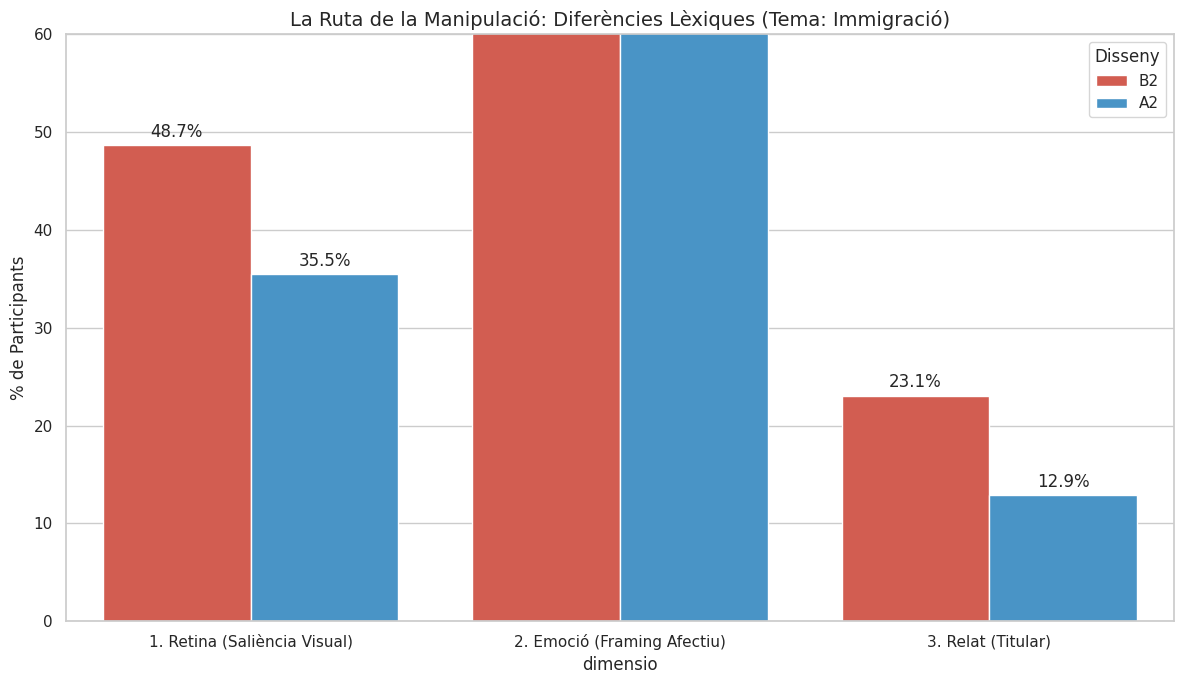

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DEFINICIÓ DELS SACS BASADA EN EL TEU 'COUNTER' REAL
# Nota: Utilitzem fragments d'arrel molt curts per caçar qualsevol variació.
dict_sacs_v2 = {
    # DIMENSIÓ 1: LA RETINA (Visual)
    # Hipòtesi: El grup B veu "Alarma/Vermell/Pic", el grup A veu "Geografia/Línia"
    'visual_alarma': [
        # Immigració B2 (Realitat del Counter: 'vermell', 'roig', 'intens', 'color')
        'vermel', 'roig', 'fosc', 'intens', 'fort', 'color', 'taca', 'sang', 'foc',
        # Educació B1 (Realitat: 'pic', '2020', 'caiguda')
        'pic', '2020', 'caigud', 'baixad', 'davallad', 'enfons', 'abism'
    ],
    'visual_neutre': [
        # Immigració A2 (Realitat: 'catalunya', 'costa', 'blau')
        'blau', 'costa', 'illes', 'balear', 'catalun', 'mar', 'geog', 'mapa', 'zona',
        # Educació A1 (Realitat: 'línia', 'constant')
        'lini', 'linia', 'constant', 'establ', 'tendenci', 'pla', 'suau', 'manten'
    ],

    # DIMENSIÓ 2: L'EMOCIÓ (Impacte - s4_percep_paraules)
    # Ampliem per capturar sentiments negatius expressats en català/castellà
    'emocio_negativa': [
        'preocup', 'perill', 'crisi', 'greu', 'por', 'mied', 'desastr', 'fatal',
        'dolent', 'mal', 'inestab', 'problem', 'satur', 'massifi', 'retroc',
        'retall', 'descontrol', 'trist', 'negati', 'alarma', 'caos'
    ],

    # DIMENSIÓ 3: EL RELAT (Narrativa - s5_record_tema)
    'relat_inestabilitat': [
        'augment', 'dispar', 'molt', 'invasi', 'descontrol', 'perdu', 'perdud',
        'caigud', 'insuficien', 'satur', 'massa', 'excessi', 'limit', 'sostre'
    ]
}

# 2. FUNCIÓ DE CERCA AGRESSIVA (Substring matching)
def check_sac_aggressive(text, sac_list):
    if pd.isna(text) or text == '':
        return 0
    # Normalitzem a minúscules
    text_clean = str(text).lower()

    for term in sac_list:
        # Cerca directa de subcadena (molt més permissiva que regex)
        if term in text_clean:
            return 1
    return 0

# 3. APLICACIÓ DE LA NOVA LÒGICA
df['has_visual_alarma'] = df['s5_record_visual'].apply(lambda x: check_sac_aggressive(x, dict_sacs_v2['visual_alarma']))
df['has_emocio_negativa'] = df['s4_percep_paraules'].apply(lambda x: check_sac_aggressive(x, dict_sacs_v2['emocio_negativa']))
df['has_relat_inestabilitat'] = df['s5_record_tema'].apply(lambda x: check_sac_aggressive(x, dict_sacs_v2['relat_inestabilitat']))

# 4. DEBUG: VERIFICACIÓ NUMÈRICA (La prova de foc)
# Si això imprimeix zeros, el problema són les dades, no el codi.
print(">>> CONTROL DE QUALITAT (Sumatori de deteccions) <<<")
print(df[['has_visual_alarma', 'has_emocio_negativa', 'has_relat_inestabilitat']].sum())
print("-" * 50)

# 5. VISUALITZACIÓ
summary_h3 = df.melt(
    id_vars=['grup_experimental'],
    value_vars=['has_visual_alarma', 'has_emocio_negativa', 'has_relat_inestabilitat'],
    var_name='dimensio',
    value_name='presencia'
)

# Neteja etiquetes
summary_h3['dimensio'] = summary_h3['dimensio'].replace({
    'has_visual_alarma': '1. Retina (Saliència Visual)',
    'has_emocio_negativa': '2. Emoció (Framing Afectiu)',
    'has_relat_inestabilitat': '3. Relat (Titular)'
})

plt.figure(figsize=(12, 7))

# Filtrem per veure l'efecte en IMMIGRACIÓ (A2 vs B2)
data_plot = summary_h3[summary_h3['grup_experimental'].isin(['A2', 'B2'])]

# Gràfic
ax = sns.barplot(
    data=data_plot,
    x='dimensio',
    y='presencia',
    hue='grup_experimental',
    palette={'A2': '#3498db', 'B2': '#e74c3c'},
    errorbar=None,
    estimator=lambda x: sum(x)*100.0/len(x) # Assegurem que calcula % real
)

plt.title('La Ruta de la Manipulació: Diferències Lèxiques (Tema: Immigració)', fontsize=14)
plt.ylabel('% de Participants', fontsize=12)
plt.ylim(0, 60) # Ajustem l'escala perquè es vegin bé les diferències
plt.legend(title='Disseny')

# Afegim valors sobre les barres per confirmar que no són 0
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

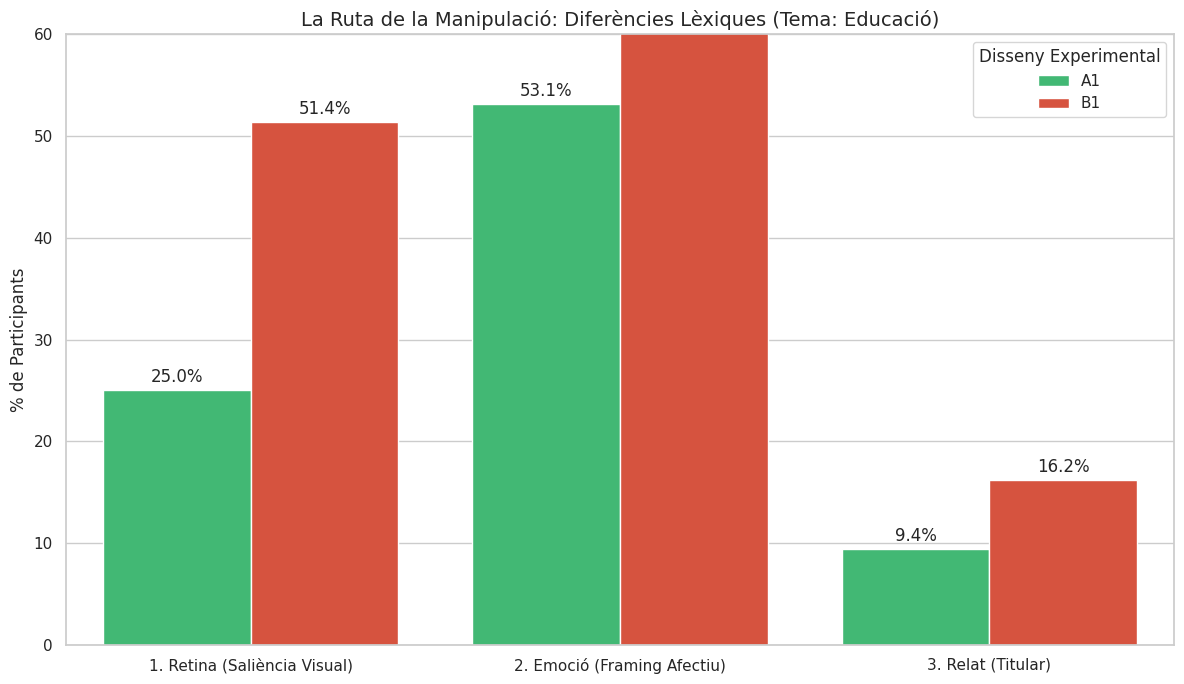

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

# 1. FILTRATGE: Ara seleccionem els grups d'EDUCACIÓ (A1 i B1)
# A1 = Control (Neutre)
# B1 = Persuasiu (Eix Truncat)
data_edu = summary_h3[summary_h3['grup_experimental'].isin(['A1', 'B1'])]

# 2. GENERACIÓ DEL GRÀFIC
ax = sns.barplot(
    data=data_edu,
    x='dimensio',
    y='presencia',
    hue='grup_experimental',
    palette={'A1': '#2ecc71', 'B1': '#ef4026'}, # Verd (Estable) vs Taronja (Alerta/Truncat)
    errorbar=None,
    estimator=lambda x: sum(x)*100.0/len(x)
)

plt.title('La Ruta de la Manipulació: Diferències Lèxiques (Tema: Educació)', fontsize=14)
plt.ylabel('% de Participants', fontsize=12)
plt.xlabel('')
plt.ylim(0, 60) # Mantenim escala per comparar amb Immigració
plt.legend(title='Disseny Experimental')

# 3. ETIQUETES DE DADES
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()